# Настройка рабочей среды

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

--2021-02-05 10:08:29--  https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233333392 (223M) [application/x-gzip]
spark-2.4.7-bin-hadoop2.7.tgz: Operation not supported

Cannot write to ‘spark-2.4.7-bin-hadoop2.7.tgz’ (Success).
tar: spark-2.4.7-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
! pip install findspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyspark.sql.functions import *
from pyspark.sql.types import *

from datetime import datetime, date

# Описание задания
Данные:
- чековые данные (transactions.parquet, для чтения через pandas дополнительно нужно установить библиотеку pyarrow)
- справочник товаров (materials.csv)
- справочник магазинов (plants.csv)
- справочник клиентов (clients.csv)

Более подробное описание данных дано в файле data description.

Цели: 
1. проанализировать данные и определить оптимальную методологию определения отточных клиентов
2. разработать модель вероятности оттока клиентов по выбранной вами методологии
3. дать интерпретацию разработанной модели, ответить на вопросы: какие признаки наиболее влияют на отток клиентов
Рекомендую подумать о репрезентативности полученных вероятностей, насколько они соответствуют действительности.

In [ ]:
descriptinon = pd.read_excel('/gdrive/MyDrive/Lenta/data description.xlsx')
descriptinon.drop('Key', axis=1)

,Table,Field,Meaning
0,transactions,chq_id,ID of transaction
1,transactions,plant,ID of store
2,transactions,chq_date,Date of transaction
3,transactions,chq_position,Position of material in transaction
4,transactions,client_id,ID of client
5,transactions,material,ID of material (item)
6,transactions,sales_count,Count of item in the check position
7,transactions,sales_sum,Amount in rubles by the check position
8,transactions,is_promo,Fact of selling the position of the check for ...
9,plants,plant,ID of store


# Загрузка данных

Т.к. из-за нехватки памяти коллаб не смог прочитать файл с транзакциями, то все данные были объединены в один файл data в Jupyter (data_reading.ipynb)

In [ ]:
# Загружаем сджойненый ранее датафрейм
%%time
data = spark.read.csv('/gdrive/MyDrive/Lenta/processing_results/transactions_materials_plants.csv', inferSchema=True, header=True)
data.show(5)

+--------------------+--------------------+-------------------+------------+--------------------+--------------------+-----------+---------+--------+----------+--------------+------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+
|              chq_id|               plant|           chq_date|chq_position|           client_id|            material|sales_count|sales_sum|is_promo|plant_type|          city|hier_level_1|        hier_level_2|        hier_level_3|        hier_level_4|              vendor|is_private_label|is_alco|
+--------------------+--------------------+-------------------+------------+--------------------+--------------------+-----------+---------+--------+----------+--------------+------------+--------------------+--------------------+--------------------+--------------------+----------------+-------+
|ce5b3d1c531348c5d...|7cd86ecb09aa48c6e...|2016-11-01 00:00:00|           4|90fca68123e692a00...|232cfe8b2

# EDA

## Исторические данные по сети

In [ ]:
%%time
#Изменение формата времени
data = data.withColumn('chq_date', to_date(col('chq_date'),'yyyy-MM-dd'))

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 33 ms


In [ ]:
%%time
# Анализ показателй по сети за все время
year_dinamic = data.groupBy('chq_date').agg(sum('sales_sum'),
                                            countDistinct('client_id')
                                            ).orderBy('chq_date')
year_dinamic_pd = year_dinamic.toPandas()

CPU times: user 78.1 ms, sys: 14.6 ms, total: 92.7 ms
Wall time: 5min


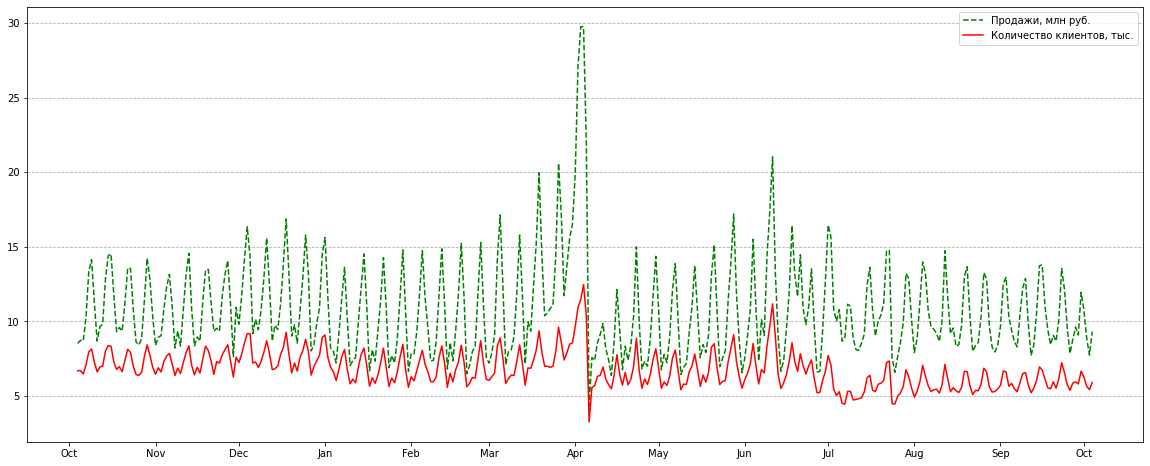

In [ ]:
# масштаб для графика
year_dinamic_pd['sum(sales_sum)'] = year_dinamic_pd['sum(sales_sum)'] / 1000000
year_dinamic_pd['count(DISTINCT client_id)'] = year_dinamic_pd['count(DISTINCT client_id)'] / 1000

# график
plt.figure(figsize=(20,8))

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

plt.plot( 'chq_date', 'sum(sales_sum)', data=year_dinamic_pd, color='green', linestyle='--', label='Продажи, млн руб.')
plt.plot( 'chq_date', 'count(DISTINCT client_id)', data=year_dinamic_pd, color='red', label='Количество клиентов, тыс.')

axes = plt.gca()
axes.xaxis.set_major_locator(locator)
axes.xaxis.set_major_formatter(fmt)

plt.grid(axis='y', ls='--')
plt.legend()
plt.show()


In [ ]:
del year_dinamic_pd, year_dinamic

- данные представлены накопительно за год (октябрь 2016 - октябрь 2017) по 100 тыс клиентов
- в апреле заметен резкий всплеск и затем выравнивание по объему продаж и количеству клиентов, что похоже на анамалию (предположительно является особенностью работы системы)
- временной ряд имеет ярко выраженную цикличность с еженедельными пиками в выходные дни
- заметно снижение количества транзакций в июне-июле 2017 года, при этом эффект на объем продаж не такой значительный
- в целом по году среднее количество совершаемых транзакций в день колеблется в районе 7-7.5 тыс, средний товарооборот 10-11 млн. руб 

## Оценка потребителей
- демографическая (пол, год рождения, город проживания)
- покупательская активность 

### Демографические данные

In [ ]:
clients = pd.read_csv('/gdrive/MyDrive/Lenta/data/clients.csv')
clients.shape

(99995, 4)

In [ ]:
clients.head()

,client_id,gender,city,birthyear
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0


In [ ]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  99995 non-null  object 
 1   gender     99640 non-null  object 
 2   city       99995 non-null  object 
 3   birthyear  98219 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


#### Client_id

In [ ]:
clients['client_id'].nunique()

99995

Все наблюдения в признаке уникальны и не несут ценности для анализа.

#### Gender

In [ ]:
clients['gender'].unique()

array(['M', 'F', nan], dtype=object)

- признак содержит менее 1% пропусков, которые можно заменить средним значением
- признак бинальный, сделаем замену М -> 0, F -> 1

In [ ]:
clients['gender'].fillna(clients['gender'].mode()[0], inplace=True)
clients['gender'].replace(['M', 'F'], [0, 1], inplace=True)

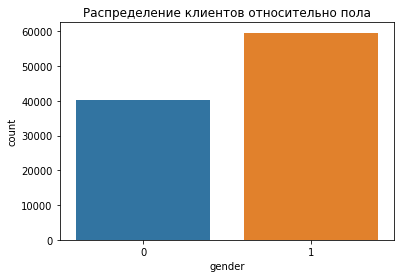

In [ ]:
sns.countplot(data=clients, x='gender')
plt.title('Распределение клиентов относительно пола')
plt.show()

Доля мужчин составляет 40%, доля женщи 60%.

#### City

In [ ]:
clients['city'].unique()

array(['Other', 'Moscow', 'St. Petersburg'], dtype=object)

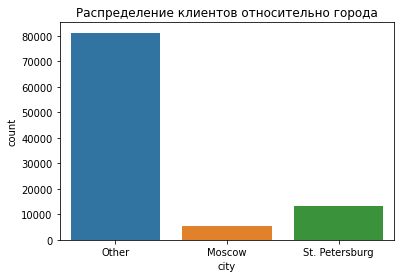

In [ ]:
sns.countplot(data=clients, x='city')
plt.title('Распределение клиентов относительно города')
plt.show()

Из распределения видно, что около 5% клиентов проживают в Москве, 13% в Санкт Петербурге и 82% в регионах. Кроме этого фича является категориальной и необходимо ее закодировать (One Hot Encoding)

In [ ]:
one_hot = pd.get_dummies(clients['city'])
clients.drop('city',axis = 1, inplace=True)
clients = clients.join(one_hot)

In [ ]:
clients.head()

,client_id,gender,birthyear,Moscow,Other,St. Petersburg
0,1a47d62dddacc03fe90c15652f7ae1a4,0,1990.0,0,1,0
1,9cb909f701d25d548e953bff81192b56,1,1969.0,0,1,0
2,d5da0f5b841b4f83383202807995027a,0,1976.0,0,1,0
3,13ed7f16810b17b8cee6de834ac79a48,1,1966.0,1,0,0
4,215fe3ea7d5bf0415e5504e2a7f33551,1,1988.0,0,1,0


#### Birthyear

Переведем признак в возраст (относительно даты наблюдения)

In [ ]:
clients['age'] = (2017 - clients['birthyear'])
clients.drop('birthyear', axis=1, inplace=True)

In [ ]:
clients['age'].describe()

count    98219.000000
mean        41.874037
std         14.964637
min        -32.000000
25%         30.000000
50%         40.000000
75%         53.000000
max        117.000000
Name: age, dtype: float64

In [ ]:
clients['age'].isna().sum()

1776

- в признаке отсутсвует 1.7% данных
- очевидны выбросы из-за некорректного заполнения года рождения

Посмотрим на распределение значений ниже:

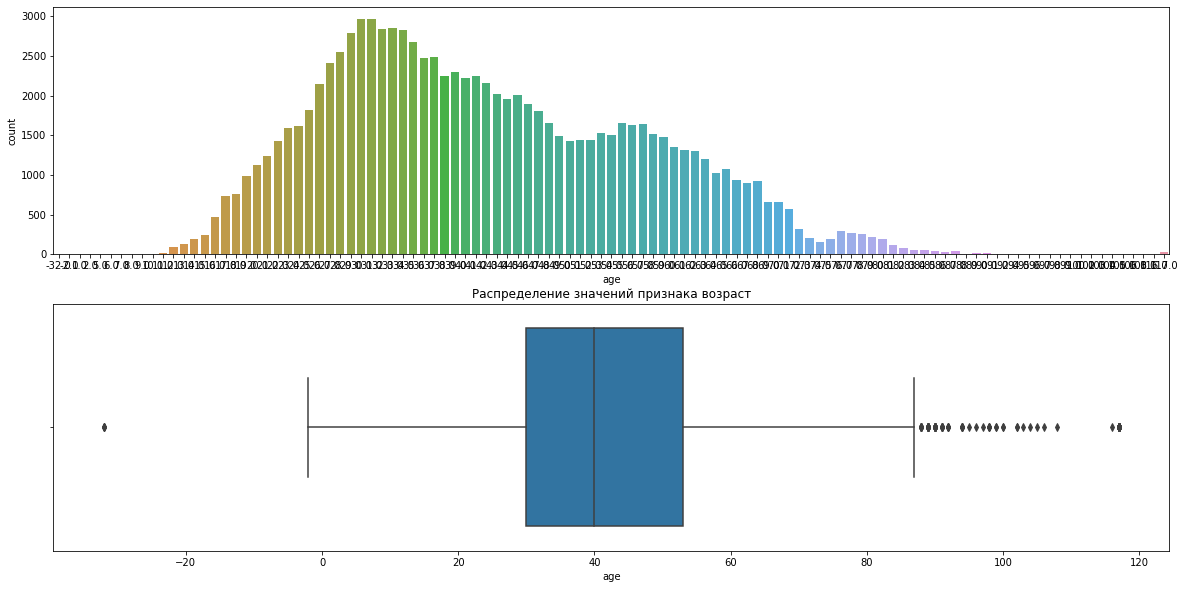

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1) 
sns.countplot(data=clients, x='age')
plt.subplot(2,1,2) 
sns.boxplot(data=clients, x='age')

plt.title('Распределение значений признака возраст')
plt.show()

Избавимся от выбросов и заменим пропущенные значения на max+1 значение


In [ ]:
# Зададим параметр alpha, ограничивающий 1% минимальных и максимальных значений
alpha = 0.01

# зададим минимум и максимум
min_age = clients['age'].quantile(alpha/2)
max_age = clients['age'].quantile(1-alpha/2)

# выберем хвосты и заменим на NaN
clients['age'] = np.where(clients['age'] < min_age, np.nan, clients['age'])
clients['age'] = np.where(clients['age'] > max_age, np.nan, clients['age'])


In [ ]:
# заменим пропуски значением 82(следующим из распределения)
clients['age'] = clients['age'].fillna(82)
clients['age'] = clients['age'].astype(int)

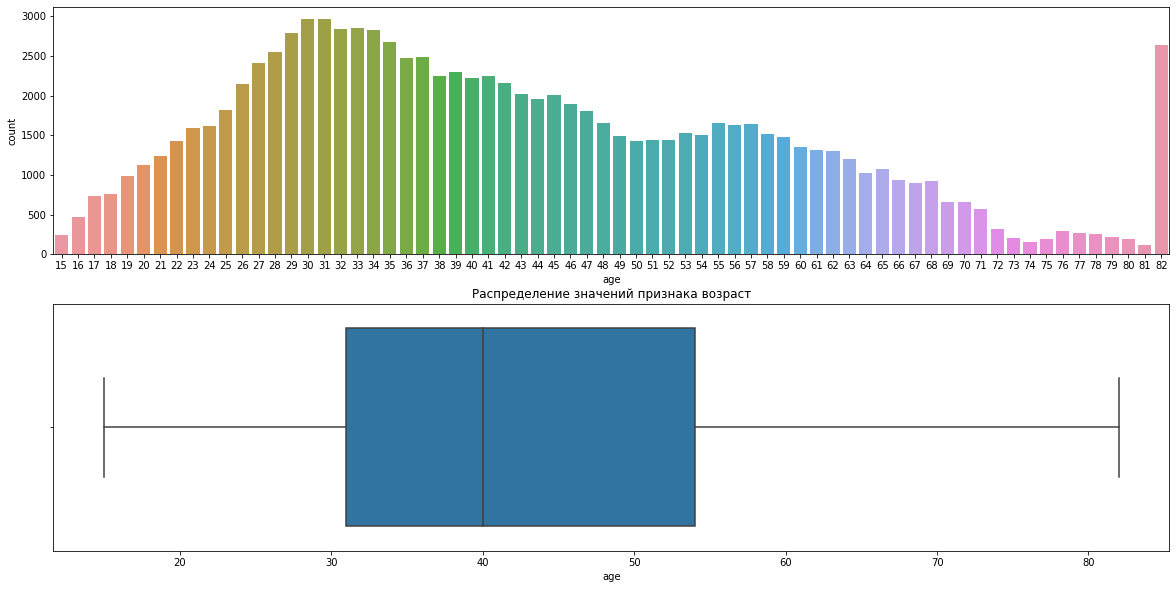

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1) 
sns.countplot(data=clients, x='age')
plt.subplot(2,1,2) 
sns.boxplot(data=clients, x='age')

plt.title('Распределение значений признака возраст')
plt.show()

In [ ]:
clients

,client_id,gender,Moscow,Other,St. Petersburg,age
0,1a47d62dddacc03fe90c15652f7ae1a4,0,0,1,0,27
1,9cb909f701d25d548e953bff81192b56,1,0,1,0,48
2,d5da0f5b841b4f83383202807995027a,0,0,1,0,41
3,13ed7f16810b17b8cee6de834ac79a48,1,1,0,0,51
4,215fe3ea7d5bf0415e5504e2a7f33551,1,0,1,0,29
...,...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,0,0,1,0,32
99991,e261c97d40ab839926c712b4aa6cefd8,1,0,0,1,35
99992,678ef46f41f8c89f7e8578c9e9592e3e,0,0,1,0,53
99993,274facf0609ceba803f5853bd2222208,1,0,1,0,66


### Оценка потребительской активности

In [ ]:
customer_info = data.select('chq_id', 'chq_date', 'client_id',
                                 'sales_count', 'sales_sum', 'is_promo',
                                 'is_private_label', 'is_alco', 'hier_level_2')

Сгенерируем фичи, отражающие продажи в рублях при условии is_promo, is_private_label, is_alco.
Например, sales_sum_with_promo = sales_sum * is_promo

In [ ]:
customer_info = customer_info.withColumn('sales_sum_with_promo', col('sales_sum')*col('is_promo')) \
                                              .withColumn('pl_sum', col('sales_sum')*col('is_private_label')) \
                                              .withColumn('alco_sum', col('sales_sum')*col('is_alco'))

Для оценки необходимо сгруппировать информацию по клиентам:
- first_purchase - дата первого заказа
- last_purchase - дата последнего заказа
- total_sum - общая сумма покупок за год в рублях
- total_items - общая сумма покупок за год в штуках
- promo_sum - общая сумма промо-покупок за год в рублях
- pl_sum - общая сумма покупок ТМ сети за год в рублях
- alco_sum - общая сумма покупок алкоголя сети за год в рублях
- total_days_with_order - количество чеков(визитов) с первого до последнего дня

In [ ]:
customer_info = customer_info.groupby('client_id').agg(min('chq_date').alias('first_purchase'), 
                                                              max('chq_date').alias('last_purchase'),
                                                              sum('sales_sum').alias('total_sum'),
                                                              sum('sales_count').alias('total_items'),
                                                              sum('sales_sum_with_promo').alias('promo_sum'),
                                                              sum('pl_sum').alias('pl_sum'),
                                                              sum('alco_sum').alias('alco_sum'), 
                                                              count('hier_level_2').alias('total_product_categories'),
                                                              countDistinct('chq_date').alias('total_days_with_order'))

Добавим еще 2 фичи, описывающих 'время жизни' клиента и частоту его визитов:
- lifetime - время, прошедешее от первого заказа до последнего
- frequency = lifetime / total_days_with_order - частота визитов в среднем с первого до последнего дня (равно 0. при условии, что за год клиент совершил только одну покупку)
- avg_check_sum = total_sum / total_days_with_order - средний чек

In [ ]:
customer_info = customer_info.withColumn('lifetime', datediff(col('last_purchase'),col('first_purchase')))
customer_info = customer_info.withColumn('frequency', (col('lifetime') / col('total_days_with_order')))
customer_info = customer_info.withColumn('avg_check_sum', (col('total_sum') / col('total_days_with_order')))

In [ ]:
customer_info.show(3)

+--------------------+--------------+-------------+---------+------------------+------------------+--------+--------+------------------------+---------------------+--------+------------------+------------------+
|           client_id|first_purchase|last_purchase|total_sum|       total_items|         promo_sum|  pl_sum|alco_sum|total_product_categories|total_days_with_order|lifetime|         frequency|     avg_check_sum|
+--------------------+--------------+-------------+---------+------------------+------------------+--------+--------+------------------------+---------------------+--------+------------------+------------------+
|18d0bbdb1998c1e17...|    2016-10-07|   2017-09-27| 187813.0|2585.2550000000006|          83245.62|80637.71|  5163.0|                    1027|                   51|     355|  6.96078431372549| 3682.607843137255|
|ca08b9231e829a4ac...|    2016-10-05|   2017-04-28|   3013.0|            44.286|2194.8900000000003|  285.23|     0.0|                      44|          

In [ ]:
customer_info_pd = customer_info.toPandas()

#### First&Last purchase

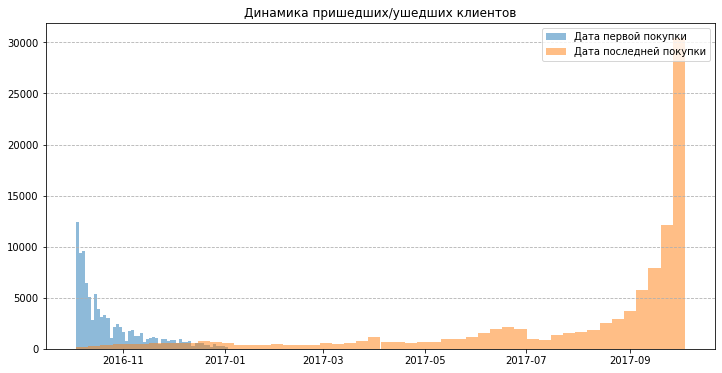

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(customer_info_pd['first_purchase'], bins=50, alpha=0.5, label='Дата первой покупки')
plt.hist(customer_info_pd['last_purchase'], bins=50, alpha=0.5, label='Дата последней покупки')

plt.grid(axis='y', ls='--')
plt.title('Динамика пришедших/ушедших клиентов')
plt.legend(loc='upper right')
plt.show()

График отражает количество новых клиентов в перспективе года и количество ушедших. При этом очевидно, что первые и последние месяцы наблюдений не несут полезной информации, т.к. являются граничными значяениями в выборке.
- Новые клиенты перестали приходить в сеть с января 2017 года (обусловлено предоставленной выборкой)
- Отток клиентов наблюдается в течение всего года и составляет около 700 человек ежедневно

Очевидно, что задача по удержанию клиентов является приоритетной, но так же важно обратить внимание на привлечение новых покупателей.

#### Total_days_with_order, Lifetime, Frequency, Avg_check_sum

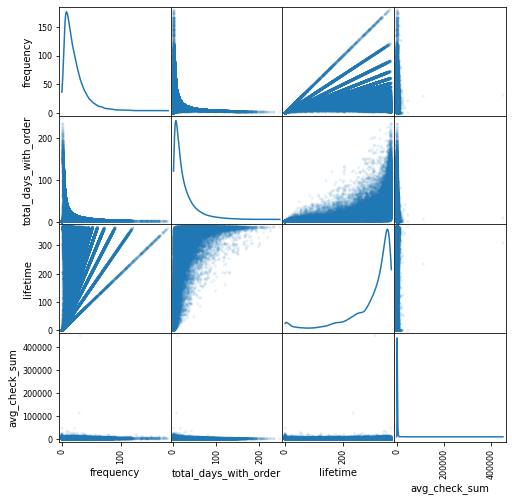

In [ ]:
pd.plotting.scatter_matrix(customer_info_pd[['frequency', 'total_days_with_order','lifetime', 'avg_check_sum']], alpha=0.1, figsize=(8,8), diagonal='kde');

#### Total_days_with_order

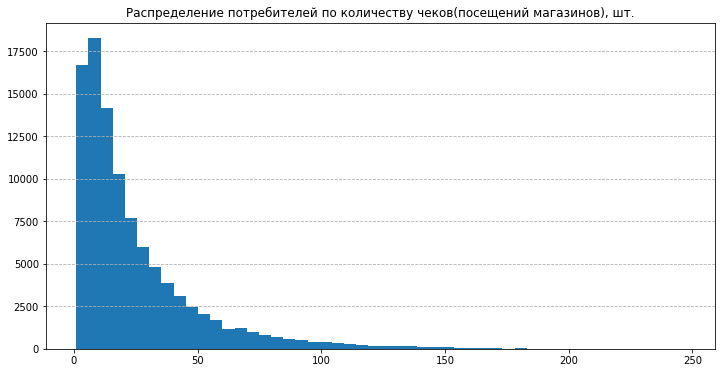

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(customer_info_pd['total_days_with_order'], bins=50)

plt.grid(axis='y', ls='--')
plt.title('Распределение потребителей по количеству чеков(посещений магазинов), шт.')

plt.show()

#### Lifetime

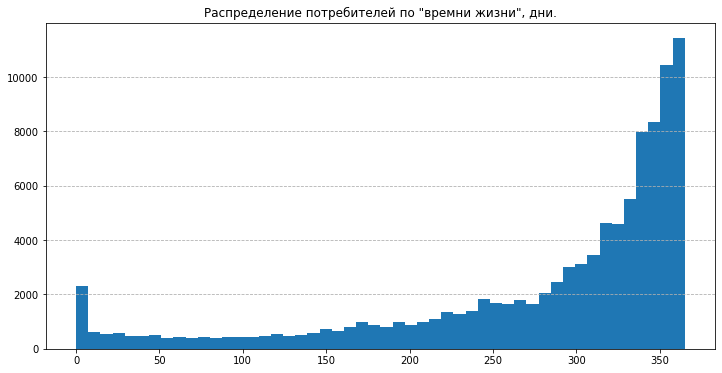

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(customer_info_pd['lifetime'], bins=50)

plt.grid(axis='y', ls='--')
plt.title('Распределение потребителей по "времни жизни", дни.')

plt.show()

#### Frequency

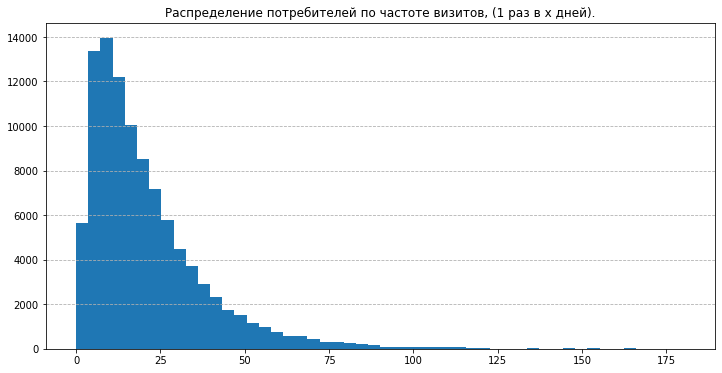

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(customer_info_pd['frequency'], bins=50)

plt.grid(axis='y', ls='--')
plt.title('Распределение потребителей по частоте визитов, (1 раз в х дней).')

plt.show()

#### Avg_check_sum

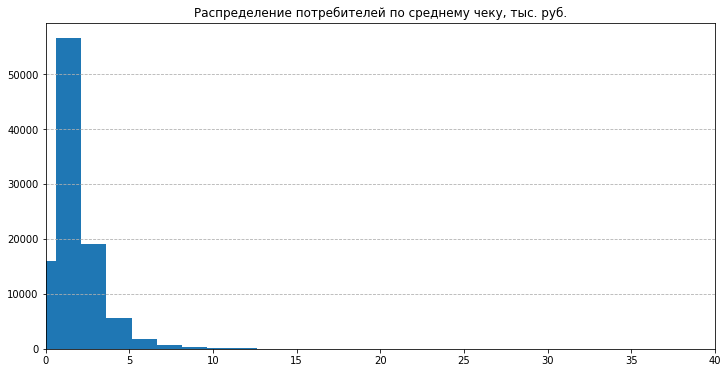

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(customer_info_pd['avg_check_sum']/1000, bins=300)

plt.grid(axis='y', ls='--')
plt.title('Распределение потребителей по среднему чеку, тыс. руб.')
ax = plt.gca()
ax.set_xlim(0, 40)
#ax.set_xticks(np.linspace(0,40, 41))
plt.show()

#### Анализ потребительской корзины
- total_sum - общая сумма покупок за год в рублях
- promo_sum - общая сумма промо-покупок за год в рублях
- pl_sum - общая сумма покупок ТМ сети за год в рублях
- alco_sum - общая сумма покупок алкоголя сети за год в рублях

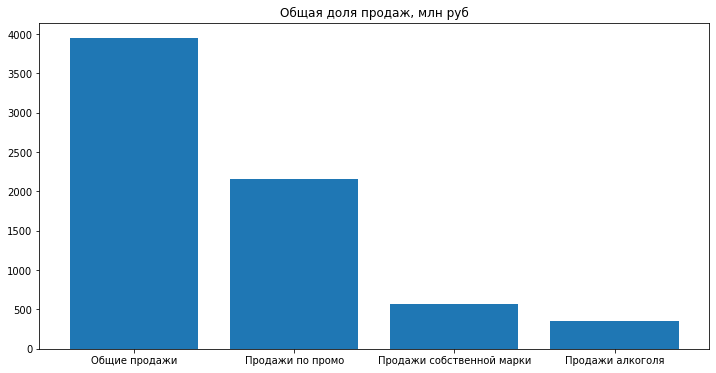

In [ ]:
plt.figure(figsize=(12,6))

sales = []
sales.append(customer_info_pd['total_sum'].sum()/1000000)
sales.append(customer_info_pd['promo_sum'].sum()/1000000)
sales.append(customer_info_pd['pl_sum'].sum()/1000000)
sales.append(customer_info_pd['alco_sum'].sum()/1000000)

labels = ['Общие продажи', 'Продажи по промо', 'Продажи собственной марки', 'Продажи алкоголя']

plt.bar(labels, sales)

plt.title('Общая доля продаж, млн руб')
plt.show()

- Общие продажи за год составили почти 4 млрд рублей
- Из них промо-продажи составляют более 50%
- Продажи собственной ТМ и алкоголя около 13% и 10% соответственно

# Выбор метрики оценки отточных клиентов

Для оценки отток/не отток я выбрал следующую метрику:
- next_order (дата следующего предполагаемого визита) = last_purchase + frequency
- deadline (последний день наблюдений)
- Churn при условии next_order <= deadline

In [ ]:
# считаем предполагаемую дату следующего заказа
customer_info_pd['next_order'] = customer_info_pd['last_purchase'] + pd.to_timedelta(customer_info_pd['frequency'].astype(int), unit='D')


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  PerformanceWarning,


In [ ]:
deadline = datetime.strptime('01/10/2017', '%d/%m/%Y')
customer_info_pd['churn'] = customer_info_pd['next_order'] <= deadline.date()

In [ ]:
customer_info_pd

,client_id,first_purchase,last_purchase,total_sum,total_items,promo_sum,pl_sum,alco_sum,total_product_categories,total_days_with_order,lifetime,frequency,avg_check_sum,next_order,churn
0,18d0bbdb1998c1e17d9811f25d2a8b22,2016-10-07,2017-09-27,187813.0,2585.255,83245.62,80637.71,5163.00,1027,51,355,6.960784,3682.607843,2017-10-03,False
1,ca08b9231e829a4ac01842540584d827,2016-10-05,2017-04-28,3013.0,44.286,2194.89,285.23,0.00,44,11,205,18.636364,273.909091,2017-05-16,True
2,13061ada9e45949d95c8d745e8ebe2eb,2016-10-13,2017-06-21,11587.0,243.386,6715.24,1082.27,279.84,146,38,251,6.605263,304.921053,2017-06-27,True
3,63210675b4ee2032ac136d4135f80e53,2016-10-06,2017-10-04,57527.0,928.299,31439.10,5706.75,226.76,940,112,363,3.241071,513.633929,2017-10-07,False
4,00cb3cc5a220082fd307aa655d953c41,2016-10-10,2017-09-23,91023.0,839.090,35913.86,12084.52,11407.32,675,26,348,13.384615,3500.884615,2017-10-06,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,a5e8411a762782c3f949a9fd41280770,2016-12-31,2016-12-31,5134.0,56.496,2911.86,373.79,0.00,40,1,0,0.000000,5134.000000,2016-12-31,True
99996,eb900f4e3326f9915447326e3d028c77,2016-11-17,2016-11-29,1080.0,12.268,305.02,327.49,259.03,14,2,12,6.000000,540.000000,2016-12-05,True
99997,aac50f5c36655e115b998f2dec681060,2016-12-30,2016-12-30,676.0,9.000,664.00,568.22,0.00,5,1,0,0.000000,676.000000,2016-12-30,True
99998,8530eee4e378ed44409834d0f1bda78d,2016-10-04,2016-10-06,906.0,15.940,206.27,110.35,0.00,15,2,2,1.000000,453.000000,2016-10-07,True


In [ ]:
customer_info_pd[
         customer_info_pd['last_purchase'] <= datetime.strptime('1/10/2017', '%d/%m/%Y').date()
         ].groupby('churn')['client_id'].count()

churn
False    34624
True     50655
Name: client_id, dtype: int64

In [ ]:
customer_info_pd.groupby('churn')['avg_check_sum', 'frequency', 'lifetime','total_days_with_order', 'total_sum', 'promo_sum'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,avg_check_sum,frequency,lifetime,total_days_with_order,total_sum,promo_sum
churn,,,,,,
False,1799.066148,21.878597,338.573189,32.172540,51917.164305,28330.394609
True,1746.896745,20.290863,221.105616,17.622347,27321.609203,15027.165864


In [ ]:
customer_info_pd.to_csv('/gdrive/MyDrive/Lenta/processing_results/customer_info_pd.csv', index=False)

In [ ]:
last_previous_diff = data.groupBy('client_id').agg(collect_set('chq_date'))
last_previous_diff_pd =  last_previous_diff.toPandas()

In [ ]:
last_previous_diff_pd['collect_set(chq_date)'] = last_previous_diff_pd['collect_set(chq_date)'].apply(lambda x: sorted(x))

In [ ]:
last_previous_diff_pd['last day - 1'] = last_previous_diff_pd['collect_set(chq_date)'].apply(lambda x: x[-2] if len(x) != 1 else x[-1])
last_previous_diff_pd['last day'] = last_previous_diff_pd['collect_set(chq_date)'].apply(lambda x: x[-1])
last_previous_diff_pd['diff'] = (last_previous_diff_pd['last day'] - last_previous_diff_pd['last day - 1']).dt.days
last_previous_diff_pd['diff'] = last_previous_diff_pd['diff'].astype(int)

In [ ]:
last_previous_diff_pd

,client_id,collect_set(chq_date),last day - 1,last day,diff
0,00469afa9d10e36d425b652eb9382d0a,"[2016-10-05, 2016-10-07, 2016-10-08, 2016-10-1...",2017-09-28,2017-10-02,4
1,00a17c88341ad1cc04cee542d91942bf,"[2016-10-29, 2017-03-11]",2016-10-29,2017-03-11,133
2,00cb3cc5a220082fd307aa655d953c41,"[2016-10-10, 2016-10-15, 2016-11-09, 2016-11-2...",2017-09-19,2017-09-23,4
3,0106450a5a3dd81188f0b1c7929e00d8,"[2016-12-04, 2016-12-12, 2017-03-30, 2017-05-2...",2017-05-21,2017-09-22,124
4,014a2bdcd69105724aeaebe7fedfbd37,"[2016-10-07, 2016-10-22, 2016-11-08, 2016-11-2...",2017-07-28,2017-08-10,13
...,...,...,...,...,...
99995,ff18516d3d061ac5d52df9ec85aa8792,"[2016-11-30, 2016-12-07, 2016-12-09, 2016-12-1...",2017-08-30,2017-09-02,3
99996,ff5a4297cb473f5dc74b82acf889fd68,"[2016-10-15, 2016-11-08, 2016-11-15, 2016-11-1...",2017-09-26,2017-10-04,8
99997,ff7a2842e29b45e1cee113d3b1a9c64e,"[2016-10-17, 2016-10-27, 2016-11-12, 2016-11-1...",2017-09-23,2017-09-26,3
99998,ff7ffa03bcfaa69e5964fac7c7cbcedb,"[2016-10-31, 2016-11-17, 2016-12-04, 2017-06-13]",2016-12-04,2017-06-13,191


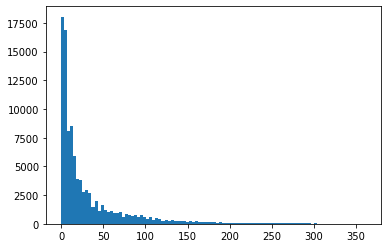

In [ ]:
plt.hist(last_previous_diff_pd['diff'], bins=100);
plt.savefig('/gdrive/MyDrive/Lenta/графики/foo.png')

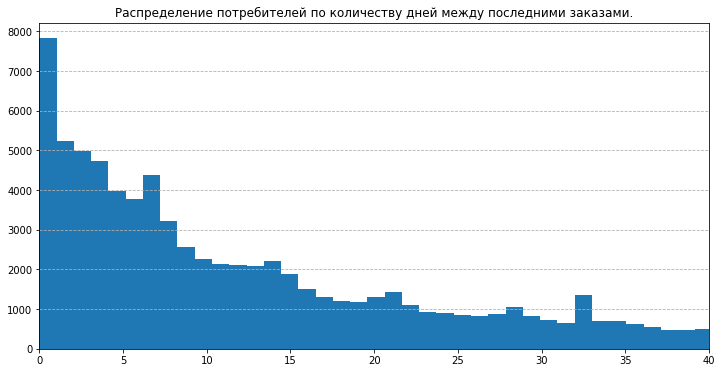

In [ ]:
plt.figure(figsize=(12,6))

plt.hist(last_previous_diff_pd['diff'], bins=350)

plt.grid(axis='y', ls='--')
plt.title('Распределение потребителей по количеству дней между последними заказами.')
ax = plt.gca()
ax.set_xlim(0, 40)
#ax.set_xticks(np.linspace(0,40, 41))
plt.show()

# ML

In [ ]:
df_s = data.withColumn('year', year(col('chq_date')))
df_s = df_s.withColumn('month', month(col('chq_date')))

In [ ]:
df_s = df_s.withColumn('date', concat(col('year'), lit('-'), col('month')))

In [ ]:
df_s = df_s.groupBy('date', 'client_id').agg(countDistinct('chq_date').alias('total_days_with_order'), sum('sales_sum').alias('total_sum'))

In [ ]:
df_s.show()

+-------+--------------------+---------------------+------------------+
|   date|           client_id|total_days_with_order|         total_sum|
+-------+--------------------+---------------------+------------------+
|2016-11|7266827577a1b0400...|                    5|14996.999999999996|
|2016-11|69827202d07107577...|                    6|            6216.0|
|2016-12|8ea9cc7cfdc55521f...|                    1| 781.0000000000001|
|2016-11|15dce9345b90c95c6...|                    2| 6596.999999999998|
|2016-11|f780091831d92a81c...|                    4| 7871.999999999999|
|2016-11|561fb6e3e6baa5fad...|                    4|            9967.0|
|2016-12|e398fa61518e4ae53...|                    4|           10775.0|
|2016-12|1a084d4be7091b369...|                    3| 3678.999999999999|
|2016-12|21657baa0be6a2d9d...|                   14|           23170.0|
| 2017-4|ea6eb308d6adf5929...|                    2|            2237.0|
|2016-12|b91626f56ac6d2735...|                    8|            

In [ ]:
df_s = df_s.withColumn('avg_check', col('total_sum') / col('total_days_with_order')) \
  .withColumn('freq', 30 / col('total_days_with_order'))

In [ ]:
df_pd = df_s.toPandas()

In [ ]:
df_pd

,date,client_id,total_days_with_order,total_sum,avg_check,freq
0,2016-11,7266827577a1b04005867a9e46ba2aef,5,14997.0,2999.4,6.0
1,2016-11,69827202d0710757756cbc0244389925,6,6216.0,1036.0,5.0
2,2016-12,8ea9cc7cfdc55521f1e4d9fcf5e1aa22,1,781.0,781.0,30.0
3,2016-11,15dce9345b90c95c64b70a0b110444a7,2,6597.0,3298.5,15.0
4,2016-11,f780091831d92a81c75b5b4934e15d23,4,7872.0,1968.0,7.5
...,...,...,...,...,...,...
797204,2017-6,097a5481fd1e53e650349bd5b498408e,1,595.0,595.0,30.0
797205,2017-6,d944decd86b6c901116ef52145613923,1,357.0,357.0,30.0
797206,2017-6,61e27c3a3de2887a731fb0406b4b05bf,1,2082.0,2082.0,30.0
797207,2017-7,6e667d848ef47af6f55cfb39886cd044,1,2152.0,2152.0,30.0


In [ ]:
list1 = pd.to_datetime(pd.Series(df_pd['date'].unique())).sort_values().astype(str).str[:7].values.tolist()

periods= []
for el in list1:
  if el[5] == '0':
    el = "".join([char for num, char in enumerate(el) if num != 5])
    periods.append(el)
  else:
    periods.append(el)


In [ ]:
periods_dict = dict(zip(periods, list(range(1, len(periods)+1))))


In [ ]:
df_pd['period'] = df_pd['date'].map(periods_dict)

In [ ]:
cols = ['total_sum',	'avg_check',	'freq']
periods = sorted(df_pd['period'].unique())

bins = np.arange(0,1+0.2,0.2,).tolist()

ratings_cols = []
for period in periods:
  for agg_col in cols:
    col = f'{period}_{agg_col}'
    df_pd[col] = \
    pd.qcut(
        x=df_pd[df_pd['period'] == period][agg_col],
        q=bins, duplicates='drop')
    ratings_cols.append(col)


In [ ]:
df_pd[ratings_cols] = (df_pd[ratings_cols].apply(lambda x: x.cat.codes) +1).astype(np.uint16)

In [ ]:
df_pd

,date,client_id,total_days_with_order,total_sum,avg_check,freq,period,1_total_sum,1_avg_check,1_freq,2_total_sum,2_avg_check,2_freq,3_total_sum,3_avg_check,3_freq,4_total_sum,4_avg_check,4_freq,5_total_sum,5_avg_check,5_freq,6_total_sum,6_avg_check,6_freq,7_total_sum,7_avg_check,7_freq,8_total_sum,8_avg_check,8_freq,9_total_sum,9_avg_check,9_freq,10_total_sum,10_avg_check,10_freq,11_total_sum,11_avg_check,11_freq,12_total_sum,12_avg_check,12_freq,13_total_sum,13_avg_check,13_freq
0,2016-11,7266827577a1b04005867a9e46ba2aef,5,14997.0,2999.4,6.0,2,0,0,0,5,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-11,69827202d0710757756cbc0244389925,6,6216.0,1036.0,5.0,2,0,0,0,4,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-12,8ea9cc7cfdc55521f1e4d9fcf5e1aa22,1,781.0,781.0,30.0,3,0,0,0,0,0,0,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-11,15dce9345b90c95c64b70a0b110444a7,2,6597.0,3298.5,15.0,2,0,0,0,5,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-11,f780091831d92a81c75b5b4934e15d23,4,7872.0,1968.0,7.5,2,0,0,0,5,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797204,2017-6,097a5481fd1e53e650349bd5b498408e,1,595.0,595.0,30.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0
797205,2017-6,d944decd86b6c901116ef52145613923,1,357.0,357.0,30.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
797206,2017-6,61e27c3a3de2887a731fb0406b4b05bf,1,2082.0,2082.0,30.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,4,0,0,0,0,0,0,0,0,0,0,0,0
797207,2017-7,6e667d848ef47af6f55cfb39886cd044,1,2152.0,2152.0,30.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,4,0,0,0,0,0,0,0,0,0


In [ ]:
df = df_pd.groupby('client_id').sum('1_total_sum')

In [ ]:
df

,total_days_with_order,total_sum,avg_check,freq,period,1_total_sum,1_avg_check,1_freq,2_total_sum,2_avg_check,2_freq,3_total_sum,3_avg_check,3_freq,4_total_sum,4_avg_check,4_freq,5_total_sum,5_avg_check,5_freq,6_total_sum,6_avg_check,6_freq,7_total_sum,7_avg_check,7_freq,8_total_sum,8_avg_check,8_freq,9_total_sum,9_avg_check,9_freq,10_total_sum,10_avg_check,10_freq,11_total_sum,11_avg_check,11_freq,12_total_sum,12_avg_check,12_freq,13_total_sum,13_avg_check,13_freq
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000d48a8891cd462fdf01ea861ec53e,36,85898.00,25503.866667,139.500000,66,2,4,3,3,5,4,5,4,1,5,5,2,2,3,3,5,4,1,4,4,2,5,5,2,5,4,1,5,4,1,5,5,2,0,0,0,0,0,0
00028a1dcb30863404a386961a69300e,30,51916.00,19160.083333,160.000000,72,3,4,2,2,4,4,2,3,4,4,5,3,5,4,1,0,0,0,2,3,3,5,5,2,5,5,2,3,2,2,3,1,1,2,2,3,0,0,0
0004274683494a9eca5e70ef97299d55,151,101130.00,10248.463487,46.315809,91,4,1,1,4,2,1,4,2,1,4,2,1,5,2,1,4,1,1,4,1,1,5,1,1,5,2,1,5,2,1,3,1,1,5,2,1,5,5,1
00072f81efcb3481861f7300c5e2a88a,8,5125.00,4879.500000,195.000000,43,1,2,3,1,1,3,0,0,0,1,2,4,0,0,0,0,0,0,1,1,4,2,3,4,1,1,4,0,0,0,0,0,0,2,4,4,0,0,0
00076596eb749cf10c2e984621dffe95,131,203833.46,21350.698648,60.944597,91,5,3,1,4,5,3,5,3,1,5,3,1,5,4,1,5,3,1,5,4,1,5,3,1,5,3,1,5,4,1,5,3,1,5,3,1,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffb2f36eb72ff56d2ef7a2685714f01,22,59813.00,26753.083333,175.000000,64,5,4,1,2,2,3,0,0,0,4,5,3,5,5,1,3,4,3,3,4,4,4,5,3,5,5,2,3,5,4,0,0,0,2,4,4,0,0,0
fffb50df95231c0f090b5aa3f5332c7f,13,19016.00,13915.833333,95.000000,27,3,2,2,1,1,3,2,1,2,0,0,0,0,0,0,4,4,3,2,2,3,5,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fffc3f2be1422d248dbeda4196ef0711,29,34752.00,13480.500000,139.285714,67,2,1,2,4,4,2,3,3,3,2,2,3,0,0,0,0,0,0,3,1,1,3,4,3,4,3,1,4,4,3,4,4,3,1,2,4,0,0,0


In [ ]:
df = df[['1_total_sum', '1_avg_check', '1_freq', '2_total_sum', '2_avg_check',
       '2_freq', '3_total_sum', '3_avg_check', '3_freq', '4_total_sum',
       '4_avg_check', '4_freq', '5_total_sum', '5_avg_check', '5_freq',
       '6_total_sum', '6_avg_check', '6_freq', '7_total_sum', '7_avg_check',
       '7_freq', '8_total_sum', '8_avg_check', '8_freq', '9_total_sum',
       '9_avg_check', '9_freq', '10_total_sum', '10_avg_check', '10_freq',
       '11_total_sum', '11_avg_check', '11_freq', '12_total_sum',
       '12_avg_check', '12_freq']]

In [ ]:
df

,1_total_sum,1_avg_check,1_freq,2_total_sum,2_avg_check,2_freq,3_total_sum,3_avg_check,3_freq,4_total_sum,4_avg_check,4_freq,5_total_sum,5_avg_check,5_freq,6_total_sum,6_avg_check,6_freq,7_total_sum,7_avg_check,7_freq,8_total_sum,8_avg_check,8_freq,9_total_sum,9_avg_check,9_freq,10_total_sum,10_avg_check,10_freq,11_total_sum,11_avg_check,11_freq,12_total_sum,12_avg_check,12_freq
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000d48a8891cd462fdf01ea861ec53e,2,4,3,3,5,4,5,4,1,5,5,2,2,3,3,5,4,1,4,4,2,5,5,2,5,4,1,5,4,1,5,5,2,0,0,0
00028a1dcb30863404a386961a69300e,3,4,2,2,4,4,2,3,4,4,5,3,5,4,1,0,0,0,2,3,3,5,5,2,5,5,2,3,2,2,3,1,1,2,2,3
0004274683494a9eca5e70ef97299d55,4,1,1,4,2,1,4,2,1,4,2,1,5,2,1,4,1,1,4,1,1,5,1,1,5,2,1,5,2,1,3,1,1,5,2,1
00072f81efcb3481861f7300c5e2a88a,1,2,3,1,1,3,0,0,0,1,2,4,0,0,0,0,0,0,1,1,4,2,3,4,1,1,4,0,0,0,0,0,0,2,4,4
00076596eb749cf10c2e984621dffe95,5,3,1,4,5,3,5,3,1,5,3,1,5,4,1,5,3,1,5,4,1,5,3,1,5,3,1,5,4,1,5,3,1,5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffb2f36eb72ff56d2ef7a2685714f01,5,4,1,2,2,3,0,0,0,4,5,3,5,5,1,3,4,3,3,4,4,4,5,3,5,5,2,3,5,4,0,0,0,2,4,4
fffb50df95231c0f090b5aa3f5332c7f,3,2,2,1,1,3,2,1,2,0,0,0,0,0,0,4,4,3,2,2,3,5,5,4,0,0,0,0,0,0,0,0,0,0,0,0
fffc3f2be1422d248dbeda4196ef0711,2,1,2,4,4,2,3,3,3,2,2,3,0,0,0,0,0,0,3,1,1,3,4,3,4,3,1,4,4,3,4,4,3,1,2,4


# Train Test Split

In [ ]:
def train_test_split(df, t, size):
  X_train_cols = [x for x in df.columns if t-size <= int(x.split('_')[0]) < t]
  X_test_cols = [x for x in df.columns if t+1-size <= int(x.split('_')[0]) < t+1]

  y_train_cols = [x for x in df.columns[::3] if int(x.split('_')[0]) == t]
  y_test_cols = [x for x in df.columns[::3] if int(x.split('_')[0]) == t+1]

  X_train = df[X_train_cols].values
  X_test = df[X_test_cols].values
  y_train = np.where(df[y_train_cols] != 0, 0, 1)
  y_test = np.where(df[y_test_cols] != 0, 0, 1)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df=df, t=7, size=6)

In [ ]:
! pip install catboost

     |████████████████████████████████| 65.8MB 126kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
model = CatBoostClassifier(#iterations=500,
                           #learning_rate=0.1,
                           train_dir = '/content')

In [ ]:
model.fit(X_train, y_train, verbose=100)

Learning rate set to 0.07361
0:	learn: 0.6570559	total: 46.9ms	remaining: 46.8s
100:	learn: 0.4672346	total: 4.26s	remaining: 37.9s
200:	learn: 0.4628057	total: 8.57s	remaining: 34.1s
300:	learn: 0.4585382	total: 13s	remaining: 30.1s
400:	learn: 0.4546992	total: 17.3s	remaining: 25.9s
500:	learn: 0.4512133	total: 21.7s	remaining: 21.7s
600:	learn: 0.4478470	total: 26s	remaining: 17.3s
700:	learn: 0.4446696	total: 30.4s	remaining: 13s
800:	learn: 0.4417213	total: 34.7s	remaining: 8.63s
900:	learn: 0.4389128	total: 39.1s	remaining: 4.29s
999:	learn: 0.4361529	total: 43.3s	remaining: 0us


In [ ]:
y_pred_train = model.predict(X_train)
print('TRAIN SCORES')
print(classification_report(y_train, y_pred_train))

TRAIN SCORES
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     66318
           1       0.70      0.63      0.67     33682

    accuracy                           0.79    100000
   macro avg       0.76      0.75      0.75    100000
weighted avg       0.78      0.79      0.78    100000



In [ ]:
y_pred_test = model.predict(X_test)
print('TEST SCORES')
print(classification_report(y_test, y_pred_test))

TEST SCORES
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     62648
           1       0.72      0.61      0.66     37352

    accuracy                           0.76    100000
   macro avg       0.75      0.73      0.74    100000
weighted avg       0.76      0.76      0.76    100000



In [ ]:
precisions = []
recalls = []
rocs = []
f1s = []
for t in range(7,13):
  X_train, X_test, y_train, y_test = train_test_split(df, t, 6)
  model.fit(X_train, y_train, verbose=100)
  y_pred_train = model.predict(X_train)

  precisions.append(precision_score(y_train, y_pred_train))
  recalls.append(recall_score(y_train, y_pred_train))
  rocs.append(roc_auc_score(y_train, y_pred_train))
  f1s.append(f1_score(y_train, y_pred_train))

Learning rate set to 0.07361
0:	learn: 0.6570559	total: 40ms	remaining: 39.9s
100:	learn: 0.4672346	total: 4.24s	remaining: 37.8s
200:	learn: 0.4628057	total: 8.55s	remaining: 34s
300:	learn: 0.4585382	total: 12.9s	remaining: 30s
400:	learn: 0.4546992	total: 17.3s	remaining: 25.9s
500:	learn: 0.4512133	total: 21.7s	remaining: 21.6s
600:	learn: 0.4478470	total: 26.1s	remaining: 17.3s
700:	learn: 0.4446696	total: 30.5s	remaining: 13s
800:	learn: 0.4417213	total: 34.9s	remaining: 8.68s
900:	learn: 0.4389128	total: 39.4s	remaining: 4.32s
999:	learn: 0.4361529	total: 43.7s	remaining: 0us
Learning rate set to 0.07361
0:	learn: 0.6553661	total: 40.4ms	remaining: 40.4s
100:	learn: 0.4598914	total: 4.24s	remaining: 37.8s
200:	learn: 0.4554405	total: 8.71s	remaining: 34.6s
300:	learn: 0.4510419	total: 13.2s	remaining: 30.6s
400:	learn: 0.4471065	total: 17.7s	remaining: 26.5s
500:	learn: 0.4435239	total: 22.2s	remaining: 22.2s
600:	learn: 0.4401104	total: 26.7s	remaining: 17.7s
700:	learn: 0.4368

In [ ]:
print(f'Precision score = {np.array(precisions).mean()}.')
print(f'Recall score = {np.array(recalls).mean()}.')
print(f'Roc-Auc score = {np.array(rocs).mean()}.')
print(f'F1 score = {np.array(f1s).mean()}.')

Precision score = 0.7411199130820608.
Recall score = 0.7384987576113335.
Roc-Auc score = 0.7787199096266924.
F1 score = 0.7392138502015485.
